<a href="https://colab.research.google.com/github/mehmetdamkaci/pn-moniDetect/blob/main/pn%C3%B6moniDetect_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Pre-Processing

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
from tqdm import tqdm
import cv2
import numpy as np
import random

def dataRead(mainPath):

    data = []
    label = []

    for folder in os.listdir(mainPath):

        dataPath = os.path.join(mainPath, folder)

        if os.path.isdir(dataPath):

            for dataFile in tqdm(os.listdir(dataPath), desc='DATA READİNG'):

                filePath = os.path.join(dataPath, dataFile)

                if os.path.isfile(filePath):

                    image = cv2.imread(filePath)
                    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    resizeImage = cv2.resize(grayImage, (256,256))
                    normalizedImage = resizeImage/255.0

                    if folder=='NORMAL':
                        label.append(0)
                    else:
                        label.append(1)

                    data.append(normalizedImage)

    return np.array(data), np.array(label) 

In [ ]:
mainPath = '/content/gdrive/My Drive/ANN Project/ChestXray/'
metaData, metaLabel = dataRead(mainPath=mainPath)

DATA READİNG: 100%|██████████| 1709/1709 [00:32<00:00, 52.27it/s]


In [ ]:
print(f'Number Of NORMAL Data : {(metaLabel==0).sum()}')
print(f'Number Of PNEUMONIA Data: {(metaLabel==1).sum()}')

Number Of NORMAL Data : 1583
Number Of PNEUMONIA Data: 1709


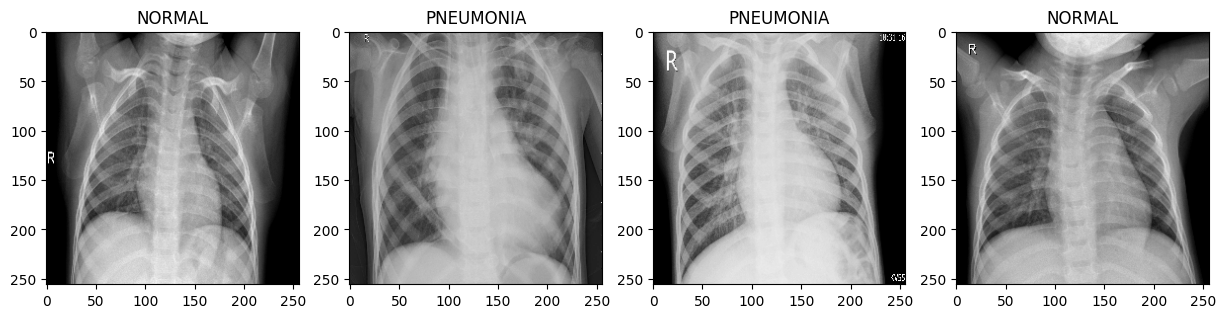

In [ ]:
import matplotlib.pyplot as plt

def drawData(metaData, metaLabel):
    plt.figure(figsize=(15,4))
    for i in range(4):
        id=random.randint(0, len(metaData))
        plt.subplot(1, 4, i+1)
        plt.imshow(metaData[id], cmap='gray')
        if metaLabel[id]==0:
            plt.title('NORMAL')
        else:
            plt.title('PNEUMONIA')
    plt.show()

drawData(metaData=metaData, metaLabel=metaLabel)

In [ ]:
from sklearn.model_selection import train_test_split

trainData, testData, trainLabel, testLabel = train_test_split(metaData, metaLabel ,random_state=104, train_size=0.8, shuffle=True)

print(f'Shape Of trainData : {trainData.shape}')
print(f'Shape Of testData : {testData.shape}')

Shape Of trainData : (2633, 256, 256)
Shape Of testData : (659, 256, 256)


In [ ]:
np.save('/content/gdrive/My Drive/ANN Project/trainData.npy', trainData)
np.save('/content/gdrive/My Drive/ANN Project/trainLabel.npy', trainLabel)
np.save('/content/gdrive/My Drive/ANN Project/testData.npy', testData)
np.save('/content/gdrive/My Drive/ANN Project/testLabel.npy', testLabel)

#Model Training

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

trainData = np.load('/content/gdrive/My Drive/ANN Project/trainData.npy')
trainLabel = np.load('/content/gdrive/My Drive/ANN Project/trainLabel.npy')
testData = np.load('/content/gdrive/My Drive/ANN Project/testData.npy')
testLabel = np.load('/content/gdrive/My Drive/ANN Project/testLabel.npy')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

def buildModel(inputImg):

    layer1 = Conv2D(128, 3, activation='relu')(inputImg)  
    layer2 = MaxPooling2D()(layer1) 
    layer3 = Flatten()(layer2)
    layer4 = Dense(1, activation='sigmoid')(layer3) 

    return layer4

imgWidth=256
imgHeight=256
inputSignal = Input(shape=(imgWidth, imgHeight, 1))
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2064512)           0         
                                                                 
 dense (Dense)               (None, 1)                 2064513   
                                                                 
Total params: 2,065,793
Trainable params: 2,065,793
Non-trainable params: 0
___________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath='/content/gdrive/MyDrive/ANN Project/Models/CNN_one_hidden_bestModel.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
    
batch_size=64
epochs=50

hist=model.fit( trainData,
                trainLabel,
                epochs=epochs,
                shuffle=True,
                batch_size=batch_size,
                verbose=2,
                validation_split=0.15,
                callbacks=callbacks_list)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.89620, saving model to /content/gdrive/MyDrive/ANN Project/Models/CNN_one_hidden_bestModel.h5
35/35 - 20s - loss: 1.3678 - accuracy: 0.7511 - val_loss: 0.2685 - val_accuracy: 0.8962 - 20s/epoch - 572ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.89620 to 0.91899, saving model to /content/gdrive/MyDrive/ANN Project/Models/CNN_one_hidden_bestModel.h5
35/35 - 6s - loss: 0.2128 - accuracy: 0.9200 - val_loss: 0.1880 - val_accuracy: 0.9190 - 6s/epoch - 160ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.91899 to 0.93165, saving model to /content/gdrive/MyDrive/ANN Project/Models/CNN_one_hidden_bestModel.h5
35/35 - 6s - loss: 0.1434 - accuracy: 0.9455 - val_loss: 0.1636 - val_accuracy: 0.9316 - 6s/epoch - 158ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.93165 to 0.93671, saving model to /content/gdrive/MyDrive/ANN Project/Models/CNN_one_hidden_bestModel.h5
35/35 - 6s - loss: 0.1123 - accuracy: 0.9558 - v

In [ ]:
filepath='/content/gdrive/MyDrive/ANN Project/Models/CNN_one_hidden_bestModel.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(64)
result = predModel.evaluate(test_dataset)

11/11 [==============================] - 1s 73ms/step - loss: 0.1339 - accuracy: 0.9454


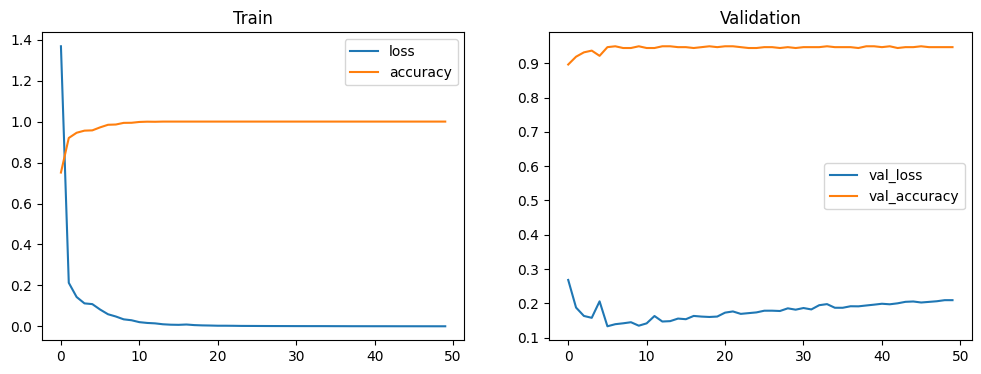

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.title('Train')
plt.legend(['loss', 'accuracy'])

plt.subplot(1,2,2)
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.title('Validation')
plt.legend(['val_loss', 'val_accuracy'])
plt.show()

Model ve Eğitim Yorumları
* Modelde bir adet gizli CNN katmanı bulunmaktadır. CNN katmanından sonra boyut azaltmak için MaxPooling uygulanmıştır. Dense katmanına giriş olabilmesi için Flatten katmanı kullanarak MaxPooling sonucu elde edile çıkış tek boyuta düşürülmüştür. Son katmanda bulunan ve bir nörondan oluşan Dense katmanı çıkış katmanını temsil etmektedir. İkili sınıflandırma olduğu için bir nörondan oluşmaktadır. Çıkış ya sıfır ya da 1 olacağı için bu katmanda aktivasyon fonksiyonu olarak sigmoid tercih edilmiştir.
* Model eğitim sırasında validation başarısı gözlemlendiğinde eğer epoch sayısı artırılırsa modelin ezberleyeceği görülmektedir. Çünkü eğitim sonuna doğru validation loss artmaya başlamıştır. En yüksek başarıya sahip modelin eğırlıkları kaydedilmiştir.
* Modelin test verisi üzerindeki başarısına bakıldığında neredeyse %94.54 başarı elde edilmiştir. Bu sonuçtan modelin öğrendiğini anlayabiliyoruz.

##Optimization

* Elde ettiğimiz sonuç iyi olduğu için yapacak olacağımız optimizasyon işlemleri sonucu az iyileştirecektir.

#Daha Derin Bir Model Kurmak

* İlk olarak daha derin bir model kullanmak doğru olacaktır. Modeli derinleştirmek için CNN katman sayısı artırılacak, uzayda verileri yakın noktalarda konumlandırmak için BatchNormalization katmanı eklenecek, modelin derinleştiği için daha fazla feature çıkaracak ve bu durumda ezberleme gerçekleşebilir bu yüzden DropOut katmanları eklenecek, CNN katmanlarından sonra modeli derinleştirmek adına Dense katmanları eklenecek.

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout

def buildModel(inputImg):

    layer1 = Conv2D(32, 3, activation='relu')(inputImg)  
    layer2 = BatchNormalization()(layer1)
    layer3 = MaxPooling2D()(layer2)
    layer4 = Dropout(0.25)(layer3)
    layer5 = Conv2D(32, 3, activation='relu')(layer4)  
    layer6 = MaxPooling2D()(layer5)
    layer7 = Dropout(0.25)(layer6)
    layer8 = Conv2D(32, 3, activation='relu')(layer7)
    layer9 = MaxPooling2D()(layer8)  
    layer10 = Dropout(0.25)(layer9)
    layer11 = Conv2D(32, 3, activation='relu')(layer10)
    layer12 = MaxPooling2D()(layer11)  
    layer13 = Dropout(0.25)(layer12) 
    layer14 = Flatten()(layer13)
    layer15 = Dense(128, activation='relu')(layer14)
    layer16 = Dropout(0.25)(layer15)  
    layer17 = Dense(64, activation='relu')(layer16)   
    layer18 = Dropout(0.25)(layer17)  
    layer19 = Dense(1, activation='sigmoid')(layer18)

    return layer19

imgWidth=256
imgHeight=256
inputSignal = Input(shape=(imgWidth, imgHeight, 1))
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 32)      9248

In [ ]:
filepath='/content/gdrive/MyDrive/ANN Project/Models/CNN_optimize_bestModel.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
    
batch_size=64
epochs=50

hist=model.fit( trainData,
                trainLabel,
                epochs=epochs,
                shuffle=True,
                batch_size=batch_size,
                verbose=2,
                validation_split=0.15,
                callbacks=callbacks_list)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.49620, saving model to /content/gdrive/MyDrive/ANN Project/Models/CNN_optimize_bestModel.h5
35/35 - 17s - loss: 0.7633 - accuracy: 0.5541 - val_loss: 0.6902 - val_accuracy: 0.4962 - 17s/epoch - 488ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.49620 to 0.54684, saving model to /content/gdrive/MyDrive/ANN Project/Models/CNN_optimize_bestModel.h5
35/35 - 8s - loss: 0.4222 - accuracy: 0.8213 - val_loss: 0.6536 - val_accuracy: 0.5468 - 8s/epoch - 221ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.54684 to 0.81013, saving model to /content/gdrive/MyDrive/ANN Project/Models/CNN_optimize_bestModel.h5
35/35 - 8s - loss: 0.2489 - accuracy: 0.9084 - val_loss: 0.6049 - val_accuracy: 0.8101 - 8s/epoch - 228ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.81013
35/35 - 8s - loss: 0.2229 - accuracy: 0.9129 - val_loss: 0.6049 - val_accuracy: 0.7291 - 8s/epoch - 221ms/step
Epoch 5/50

Epoch 5: val_accuracy d

In [ ]:
filepath='/content/gdrive/MyDrive/ANN Project/Models/CNN_optimize_bestModel.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(64)
result = predModel.evaluate(test_dataset)

11/11 [==============================] - 1s 61ms/step - loss: 0.1817 - accuracy: 0.9621


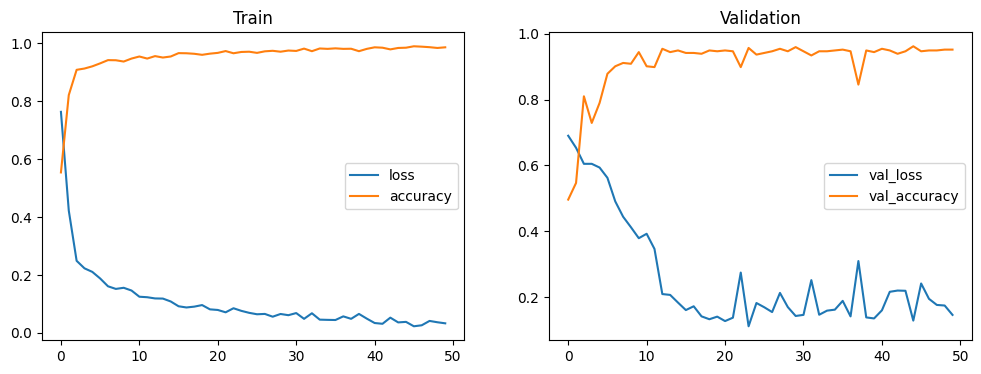

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.title('Train')
plt.legend(['loss', 'accuracy'])

plt.subplot(1,2,2)
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.title('Validation')
plt.legend(['val_loss', 'val_accuracy'])
plt.show()

Yorum
* Modelin daha derinleştirilmesi ve derinleştirilmesi sonucu eklenen BatchNormalization ve Dropout katmanı sonucunda model test verisi üzerinde daha yüksek bir başarı elde etmiştir. Bunun sebebi model daha fazla feature öğrenmiş olabilir. Modeli derinleştirirken modelin ezberlemesi sık rastalana bir durumdur fakat Dropout katmanları sayesinde bu durum önlenmiştir.

#Attention
* Test başarısı %96.21 olduğu için sonucun çok iyileşmesi beklenemez çünkü mevcut sonuç zaten yüksektir.
* Model incelendiğinde flatten katmanından önce 32 kanallı 14x14 boyutunda görüntü vardır. Bu görüntüde her bir kanalda tutulan feauture aynı öneme sahip olmayabilir. Bu yüzden flattendan önce basit bir attention layer ekleyeceğiz.

In [ ]:
import tensorflow as tf

class CustomAttentionLayer(tf.keras.layers.Layer):
    def __init__(self,  activation=None):
        super(CustomAttentionLayer, self).__init__()
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):

        self.input_dim = input_shape[-1]
        self.w = self.add_weight(
            shape=(self.input_dim,1),
            initializer="random_normal",
            trainable=True,
        )
        

    def call(self, inputs):        
        
        alphaVector = tf.reshape(self.activation(self.w), shape=[32,])
        
        return alphaVector

input_tensor = tf.keras.layers.Input(shape=(14,14,32), batch_size=None)
layer = CustomAttentionLayer(activation='tanh')(input_tensor)
layer.shape

TensorShape([32])

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout

def buildModel(inputAudio):

    layer1 = Conv2D(32, 3, activation='relu')(inputAudio)  
    layer2 = BatchNormalization()(layer1)
    layer3 = MaxPooling2D()(layer2)
    layer4 = Dropout(0.25)(layer3)
    layer5 = Conv2D(32, 3, activation='relu')(layer4)  
    layer6 = MaxPooling2D()(layer5)
    layer7 = Dropout(0.25)(layer6)
    layer8 = Conv2D(32, 3, activation='relu')(layer7)
    layer9 = MaxPooling2D()(layer8)  
    layer10 = Dropout(0.25)(layer9)
    layer11 = Conv2D(32, 3, activation='relu')(layer10)
    layer12 = MaxPooling2D()(layer11)  
    layer13 = Dropout(0.25)(layer12) 
    alphaLayer = CustomAttentionLayer()(layer13)
    attenLayer = tf.keras.layers.Softmax()(alphaLayer)
    multiplyLayer = layer13*attenLayer
    layer14 = Flatten()(multiplyLayer)
    layer15 = Dense(128, activation='relu')(layer14)
    layer16 = Dropout(0.25)(layer15)  
    layer17 = Dense(64, activation='relu')(layer16)   
    layer18 = Dropout(0.25)(layer17)  
    layer19 = Dense(1, activation='sigmoid')(layer18)

    return layer19

imgWidth=256
imgHeight=256
inputSignal = Input(shape=(imgWidth, imgHeight, 1))
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 254, 254, 32  320         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 254, 254, 32  128        ['conv2d_22[0][0]']              
 rmalization)                   )                                                           

In [ ]:
filepath='/content/gdrive/MyDrive/ANN Project/Models/CNN_optimize_atten_bestModel.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
    
batch_size=64
epochs=50

hist=model.fit( trainData,
                trainLabel,
                epochs=epochs,
                shuffle=True,
                batch_size=batch_size,
                verbose=2,
                validation_split=0.15,
                callbacks=callbacks_list)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.58228, saving model to /content/gdrive/MyDrive/ANN Project/Models/CNN_optimize_atten_bestModel.h5
35/35 - 12s - loss: 0.4920 - accuracy: 0.7431 - val_loss: 0.6595 - val_accuracy: 0.5823 - 12s/epoch - 335ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.58228 to 0.66329, saving model to /content/gdrive/MyDrive/ANN Project/Models/CNN_optimize_atten_bestModel.h5
35/35 - 10s - loss: 0.2218 - accuracy: 0.9169 - val_loss: 0.6301 - val_accuracy: 0.6633 - 10s/epoch - 279ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.66329 to 0.90633, saving model to /content/gdrive/MyDrive/ANN Project/Models/CNN_optimize_atten_bestModel.h5
35/35 - 9s - loss: 0.1964 - accuracy: 0.9240 - val_loss: 0.5859 - val_accuracy: 0.9063 - 9s/epoch - 246ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.90633
35/35 - 8s - loss: 0.1838 - accuracy: 0.9312 - val_loss: 0.5388 - val_accuracy: 0.9038 - 8s/epoch - 220ms/step
Epoch 5/50

Epo

In [ ]:
filepath='/content/gdrive/MyDrive/ANN Project/Models/CNN_optimize_atten_bestModel.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(64)
result = predModel.evaluate(test_dataset)

11/11 [==============================] - 1s 42ms/step - loss: 0.1157 - accuracy: 0.9666


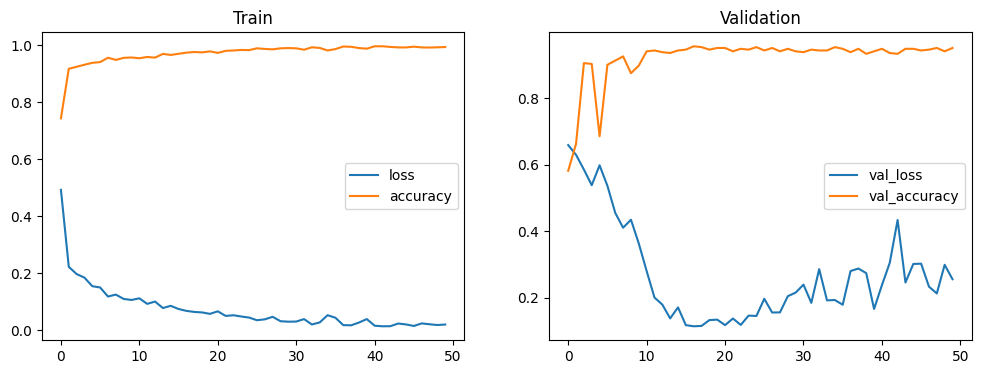

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.title('Train')
plt.legend(['loss', 'accuracy'])

plt.subplot(1,2,2)
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['val_accuracy'])
plt.title('Validation')
plt.legend(['val_loss', 'val_accuracy'])
plt.show()

#Yorum
* Modele attention katmanı eklendiğinde modelin test verisi üzerindeki başarısı %96.21'den %96.66'ya çıkmıştır. Bu durumda son flatten katmanından önceki 32 kanallı görüntüde her kanalın eşit öneme sahip olmadığını anlayabiliyoruz.